<a href="https://colab.research.google.com/github/MithunKiniStar/LSTM-StockPricePrediction/blob/main/LSTM_StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Keras and Tensorflow > 2.0

In [2]:
import pandas_datareader as pdr

In [3]:
key = '62ab16bc7c675756e484b6f72ec3e6970dfac84b'
df = pdr.get_data_tiingo('AAPL',api_key=key)

In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd


In [6]:
df = pd.read_csv('AAPL.csv')

In [7]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-07-20 00:00:00+00:00,146.15,147.0997,142.96,143.460,96350036,146.15,147.0997,142.96,143.460,96350036,0.0,1.0
1253,AAPL,2021-07-21 00:00:00+00:00,145.40,146.1300,144.63,145.530,74993460,145.40,146.1300,144.63,145.530,74993460,0.0,1.0
1254,AAPL,2021-07-22 00:00:00+00:00,146.80,148.1950,145.81,145.935,77338156,146.80,148.1950,145.81,145.935,77338156,0.0,1.0
1255,AAPL,2021-07-23 00:00:00+00:00,148.56,148.7177,146.92,147.550,71447416,148.56,148.7177,146.92,147.550,71447416,0.0,1.0
1256,AAPL,2021-07-26 00:00:00+00:00,148.99,149.8300,147.70,148.270,72434089,148.99,149.8300,147.70,148.270,72434089,0.0,1.0


In [8]:
df1 = df.reset_index()['close']
df1.shape

(1257,)

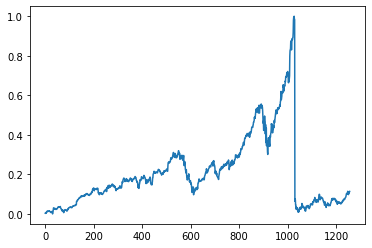

In [27]:
import matplotlib.pyplot as plt
plt.plot(df1)

### LSTM are sensitive to the scale of the data, so we apply MinMax scaler

In [9]:
import numpy as np

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)
df1.shape

[[0.00300278]
 [0.00268017]
 [0.00724638]
 ...
 [0.10837304]
 [0.11274072]
 [0.11380782]]


(1257, 1)

### Splitting dataset into train and test split

In [11]:
training_size=int(len(df1)*0.65)
test_size= len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
training_size,test_size

(817, 440)

In [13]:
len(train_data), len(test_data)

(817, 440)

In [14]:
import numpy
### conver array of values into a dataset matrix
def create_dataset(dataset,time_step=1):
  dataX, dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a= dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return numpy.array(dataX), numpy.array(dataY)

In [15]:
### reshape into X=t,t+1,t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [21]:
print(X_train.shape), print (y_train.shape)

(716, 100)
(716,)


(None, None)

In [16]:
print(X_test.shape), print (y_test.shape)

(339, 100)
(339,)


(None, None)

In [17]:
### reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [18]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 103ms/step - loss: 0.0130 - val_loss: 0.0368
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0022 - val_loss: 0.0265
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0219
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 6.5843e-04 - val_loss: 0.0209
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 4.7138e-04 - val_loss: 0.0216
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 4.3491e-04 - val_loss: 0.0198
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 4.2078e-04 - val_loss: 0.0195
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 4.0243e-04 - val_loss: 0.0195
Epoch 9/100
12/12 [==============================] - 0s 17ms/step - loss: 3.9317e-04 - val_loss: 0.0193
Epoch 10/100
12/12 [==============================] - 0s 17ms/step - loss:

In [22]:
### Predict and check performance metrics
train_predict=model.predict(X_train)
test_predict= model.predict(X_test)

In [23]:
### Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
### Calculate Root Mean Square Error(RMSE) performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

177.41756144979774

In [25]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

226.3234585152285

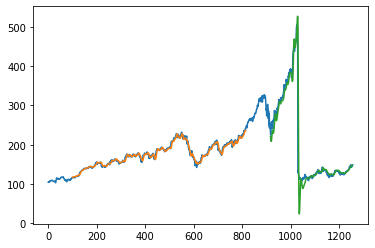

In [28]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
len(test_data)

440

In [30]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input


[0.04218781020448681,
 0.04538912050823907,
 0.03283204288266828,
 0.04455777248362125,
 0.04181556482032961,
 0.04672920389120511,
 0.04442128250943028,
 0.051766924756799726,
 0.05568790946992258,
 0.05367778439547355,
 0.04318046456223945,
 0.04184038117927341,
 0.05027794322017076,
 0.048168552709946466,
 0.0420885447687116,
 0.043329362715902375,
 0.044867976970418944,
 0.045314671431407605,
 0.04161703394877908,
 0.047200714711137626,
 0.04931010522136198,
 0.05650684931506855,
 0.05727615644232681,
 0.06147012110383171,
 0.06757494540401038,
 0.0741140559857058,
 0.06975878499106619,
 0.07767520349414342,
 0.07171927734762762,
 0.07784891800675009,
 0.07700516180266037,
 0.07869267421083981,
 0.07439944411355975,
 0.07536728211236854,
 0.07149593011713323,
 0.07740222354576137,
 0.07839487790351402,
 0.0775759380583681,
 0.07556581298391907,
 0.07531764939448088,
 0.07030474488783012,
 0.0729849116537622,
 0.06134603930911259,
 0.061966448282707975,
 0.06603633114949381,
 0.0672

In [35]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.1085899]
101
1 day input [0.04538912 0.03283204 0.04455777 0.04181556 0.0467292  0.04442128
 0.05176692 0.05568791 0.05367778 0.04318046 0.04184038 0.05027794
 0.04816855 0.04208854 0.04332936 0.04486798 0.04531467 0.04161703
 0.04720071 0.04931011 0.05650685 0.05727616 0.06147012 0.06757495
 0.07411406 0.06975878 0.0776752  0.07171928 0.07784892 0.07700516
 0.07869267 0.07439944 0.07536728 0.07149593 0.07740222 0.07839488
 0.07757594 0.07556581 0.07531765 0.07030474 0.07298491 0.06134604
 0.06196645 0.06603633 0.0672027  0.0588644  0.05653167 0.04873933
 0.05419893 0.06035338 0.05742505 0.05390113 0.05350407 0.06000596
 0.05534048 0.05948481 0.05898849 0.0588644  0.05496824 0.05330554
 0.0524866  0.05442228 0.05065019 0.05648203 0.05650685 0.05859142
 0.05955926 0.05702799 0.06010522 0.06787274 0.06578817 0.0670538
 0.07112368 0.06782311 0.07238932 0.07655847 0.07586361 0.07514393
 0.07439944 0.07854378 0.08239031 0.08395374 0.08472305 0.09139865
 0.09651082 0.10283899 0.09953842 0

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
import matplotlib.pyplot as plt

In [38]:
len(df1)

1257

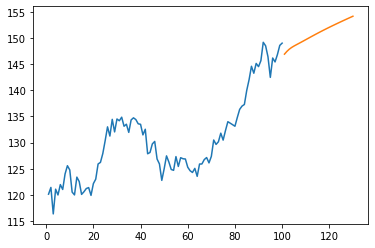

In [39]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))